# 15688 Tutorial Introduction to Pyspark


## Introduction
This tutorial will introduce you the basic concepts of pyspark as well as useful examples using python code. I am sure that you have heard the concept of big data. The complexity and volume of new data generate the requirement of new technology. The ability of dealing with big data is essential to each company and industry. Pyspark is one of the most common technology in this area so in this tutorial will give you a pyspark 101. The package used here is pyspark.

## Tutorial Agenda

- Apache Spark Architecture
- The Key Data Object - RDD
- Operations on RDD
- The Key Data Object - DataFrame
- PySpark SQL
- Simple Linear Regression with MLlib

## Apache Spark Architecture

Spark achieves high-speed data processing thourgh distributed computation. The high-level architecture is driver-worker, a node controlling over other processes(workers). The driver organizes what computational work should been done on which worker. The computational job is distributed(map) to workers and the partial results are combined(reduce) to get final output. In this tutorial we will use pyspark, a Spark library written in Python providing easy-to-write spark programming.

Frist of all, spark creates SparkContext object, it tells the computer where to find a cluster( a driver and its worker brothers)

In [4]:
import sys
sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.9-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark import SparkConf, SparkContext
sc = SparkContext()
sc


<SparkContext master=local[*] appName=pyspark-shell>

## The Key Data Object - RDD

SparkContext can be used to create RDD(Resilient Distributed Dataset). RDD is a fundamental data structure of Spark. It is immutable, distributed and fault-tolerant. So once you create a RDD, you are not able to change it. RDD is divided into several partitions across a cluster. The number of partitions should be decided by programmer and is not changeable as well. If you forget to do this, the machine will decide it by itself according to abailable capacity. The more partitions, the better ability of parallelism. The thrid property of RDD is fault-tolerant. If one worker crushes, it simplily restart its process without effecting other workers. From other aspects, you can just imagine RDD as a list in python.

You can create a RDD by two ways. The first one is to parallelizing Python collections, such as list.( See! RDD and list are similar.) Another way is to import from files. 

In [2]:
# parallelizing
data1 = ['I', 'like', 'practical', 'data', 'science','like','lot','a','good','good']
rdd1 = sc.parallelize(data1, 4) # the number of partitions

data2 = [1,2,3,4]
rdd2 = sc.parallelize(data2) # do not decide number of partitions
print("number of partitions:"+str(rdd2.getNumPartitions()))

number of partitions:32


## Opeartions on RDD

There are two opeartions on RDD. Transformations and actions. An interesting thing is that transformations are lazy. They are not computed immediately until an action runs on it. Another useful method is cache. By caching data that may be reused you keep them in memory and reduce time of disk I/O.

The basic tranformations include map(), filter(), distinct(), flatMap(). The input of these transformations is a function. Map returns a new rdd by passing each element into the function. Filter returns a new rdd with elements that return True through filter. Distinct returns distinct elements of original dataset. FlatMap is similar to map but the mapping is not restricted to one-to-one. Let's see some examples.

In [3]:
#map
mapRDD = rdd1.map(lambda x: x+'s')
print (mapRDD.collect())

['Is', 'likes', 'practicals', 'datas', 'sciences', 'likes', 'lots', 'as', 'goods', 'goods']


In [4]:
#filter
print(rdd2.filter(lambda x: x <= 2).collect())

[1, 2]


In [5]:
#distinct
print(rdd1.distinct().collect())

['like', 'good', 'lot', 'a', 'science', 'I', 'practical', 'data']


Here we can see the differences between map and flatmap.

In [7]:
#FlatMap

print(rdd2.map(lambda x: [x,x+1]).collect())
print(rdd2.flatMap(lambda x: [x,x+1]).collect())

[[1, 2], [2, 3], [3, 4], [4, 5]]
[1, 2, 2, 3, 3, 4, 4, 5]


You may be confused by the action "collect()". Remember? We mentioned before that transformations are lazy. They are not executed until an action runs on them. Here collect is an action, it just gives all the elements in a RDD. Other common actions are reduce(function), take(n), and takeOrdered(n,key = function). Reduce function takes two parameters and gives one, it is widely used to implement basic addment. Take returns the first n elements. Takeorderd is similar and it allows you to create your own sort key(ascending). You can change it into descending with a small trick.

In [8]:
#reduce
print(rdd2.reduce(lambda x,y:x+y))

10


In [12]:
#take
print(rdd2.take(2))

#takeOrderd
print(rdd2.takeOrdered(2,lambda x: -1*x)) # a trick to descend

[1, 2]
[4, 3]


In fact pyspark provides some methods that allow key-value pair transforamtions. Like dictionary in python. They are reduceByKey(),sortByKey and groupByKey(). ReduceByKey is just like reduce, only this time values are combined by their keys. SortByKey() and groupByKey() works the same way.

In [13]:
#create rdd with keys
data3 = [(1,2),(3,4),(5,6),(5,7),(3,8)]
keyRDD = sc.parallelize(data3)
#reducebykey
print(keyRDD.reduceByKey(lambda x,y : x+y).collect())
#sortbykey
print(keyRDD.sortByKey().collect())
#groupbykey
print(keyRDD.groupByKey().collect())

[(1, 2), (3, 12), (5, 13)]
[(1, 2), (3, 4), (3, 8), (5, 6), (5, 7)]
[(1, <pyspark.resultiterable.ResultIterable object at 0x1534c05494f0>), (3, <pyspark.resultiterable.ResultIterable object at 0x1534c0549490>), (5, <pyspark.resultiterable.ResultIterable object at 0x1534c05496a0>)]


Now we have a command of all useful functions. Let's combine them together and do something interesting. A famous example of distributed computation is word frequency count. In the comments below I give you the code to create RDD from local files. Since I cannot submit local files in this tutorial, I will create the RDD by hand. The text is copied from our course website.

What are the steps to do word count? First I will separate the original sentence into words and remove spaces. Next I will map each word to a tuple(word,1) and use reducebykey.

In [18]:
#file = test.txt'
#rdd = sc.textFile(file)

data4 = ['With data science, as with most disciplines, the best way to learn a particular topic is to teach it to others. The tutorial assignment of this course is meant to give you the chance to create a short tutorial on something related to data science. You can describe how to use a particular algorithm, library, methodology, or data set. Your tutorial should provide an introduction to this topic suitable for the level of other students taking this course. Ultimately, you will be graded by the course instructor and other students taking the course']
rdd4 = sc.parallelize(data4)

In [28]:
rdd4 = rdd4.flatMap(lambda x: x.split(' ')).filter(lambda x: x!='').filter(lambda x: x!=',')
wordcount = rdd4.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).collect()

In [29]:
print ('\n'.join(map(lambda x: '{0}: {1}'.format(x[0], x[1]), wordcount)))

something: 1
instructor: 1
create: 1
by: 1
this: 3
course: 3
level: 1
students: 2
algorithm,: 1
methodology,: 1
most: 1
You: 1
describe: 1
set.: 1
provide: 1
science,: 1
a: 3
how: 1
as: 1
for: 1
particular: 2
give: 1
short: 1
library,: 1
With: 1
to: 8
should: 1
topic: 2
is: 2
with: 1
teach: 1
Ultimately,: 1
other: 2
assignment: 1
you: 2
use: 1
course.: 1
data: 3
Your: 1
the: 5
be: 1
way: 1
suitable: 1
on: 1
can: 1
taking: 2
others.: 1
of: 2
an: 1
introduction: 1
learn: 1
graded: 1
it: 1
tutorial: 3
will: 1
disciplines,: 1
best: 1
related: 1
meant: 1
and: 1
The: 1
chance: 1
science.: 1
or: 1


## The Key Data Object - DataFrame
DataFrame is a distributed collection of data object. Its properties are very much like RDD. It's the distributed version of pandas dataframe or table in database.(But faster) DataFrames can be constructed from a wide sources such as structured data files, tables, databases, or existing RDDs. RDD is built by SparkContext and DataFrame is built by Spark Session.
Actually DataFrame is built on top of RDD. Therefore it's a higher level of spark interface and less flexibility. The advantage is that it requires shorter codes. The opeations on DataFrame are similar to RDD, transformations and actions. They are pretty much like those in pandas. I will give you some examples here.

In [42]:
import pyspark
from pyspark.sql import SparkSession

ss = SparkSession.builder.appName('15688tutorial').getOrCreate()

In [44]:
data = [('Mike','1997-04-01','M',3000),
  ('Jack','2000-08-19','M',4000),
  ('Amy','1978-09-05','M',4000),
  ('Oick','1966-12-01','F',4000),
  ('Lily','1989-11-17','F',10000)
]

columns = ["name","birthday","gender","salary"]
df = ss.createDataFrame(data=data, schema = columns)
df.show()

+----+----------+------+------+
|name|  birthday|gender|salary|
+----+----------+------+------+
|Mike|1997-04-01|     M|  3000|
|Jack|2000-08-19|     M|  4000|
| Amy|1978-09-05|     M|  4000|
|Oick|1966-12-01|     F|  4000|
|Lily|1989-11-17|     F|    -1|
+----+----------+------+------+



In [45]:
# group by  and sum
df.groupBy("gender").sum("salary").show(truncate=False)

+------+-----------+
|gender|sum(salary)|
+------+-----------+
|F     |3999       |
|M     |11000      |
+------+-----------+



In [59]:
# group by and average
df.groupBy("gender").avg("salary").show(truncate=False)

+------+------------------+
|gender|avg(salary)       |
+------+------------------+
|F     |1999.5            |
|M     |3666.6666666666665|
+------+------------------+



## PySpark SQL
We should all be familar with SQL. Pyspark SQL allows you to use SQL on Spark Dataframe. A temporary table is created by createOrReplaceTempView(). And any SQL script should be in sql().

In [64]:
df.createOrReplaceTempView("table1")
ss.sql("SELECT * from table1").printSchema()
result = ss.sql("SELECT * from table1")
result.show()

root
 |-- name: string (nullable = true)
 |-- birthday: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- salary: long (nullable = true)

+----+----------+------+------+
|name|  birthday|gender|salary|
+----+----------+------+------+
|Mike|1997-04-01|     M|  3000|
|Jack|2000-08-19|     M|  4000|
| Amy|1978-09-05|     M|  4000|
|Oick|1966-12-01|     F|  4000|
|Lily|1989-11-17|     F|    -1|
+----+----------+------+------+



In [72]:
result = ss.sql("SELECT gender, count(*) as num,avg(salary) as average_salary from table1 group by gender")
result.show()

+------+---+------------------+
|gender|num|    average_salary|
+------+---+------------------+
|     F|  2|            1999.5|
|     M|  3|3666.6666666666665|
+------+---+------------------+



## Simple Linear Regression with MLlib
Pyspark is not only powerful for RDD and DataFrame. It also supports machine learning. MLlib is spark's core machine learning library. In the last part of this tutorial, I'll show you how to implement a linear regression in spark. The dataset used here comes from http://millionsongdataset.com/. We wanna predict the year of songs using given features. To be clear, this tutorial is aimed at going you through linear regression process instead of finding knewledge with machine learning. So I won't give interpretion of the regression result.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.mllib.regression import LabeledPoint

In [7]:
data = sc.textFile('millionsong_bigdata.txt', 8)
sample = data.take(5)
print(sample)

['2.00500000e+03,8.00890230e-01,6.56657992e-01,3.25012011e-01,3.88967777e-01,2.59227069e-01,3.51218956e-01,3.55794257e-01,3.50315260e-01,6.40341845e-01,5.62001594e-01,5.95646033e-01,4.98571737e-01', '1.97400000e+03,6.13489242e-01,6.41458028e-01,2.78497062e-01,3.36810765e-01,3.80977949e-01,3.37200764e-01,3.53774994e-01,4.24861111e-01,5.51306540e-01,4.45964685e-01,6.22590106e-01,6.09032474e-01', '1.98700000e+03,8.43599476e-01,6.17139860e-01,5.02508467e-01,4.38770294e-01,3.11464360e-01,3.81006120e-01,4.58850780e-01,4.43217844e-01,6.05648100e-01,4.45977090e-01,5.14609707e-01,4.28761963e-01', '2.00800000e+03,8.77323637e-01,6.72525879e-01,4.71228100e-01,4.33595141e-01,2.79012358e-01,3.51656386e-01,4.67118237e-01,4.72284730e-01,6.34704607e-01,6.01637231e-01,4.91206094e-01,4.04435583e-01', '1.97000000e+03,6.52183301e-01,6.55613002e-01,5.04868026e-01,5.10029804e-01,3.70969860e-01,6.92052424e-01,4.04965750e-01,2.42278423e-01,5.86823050e-01,2.77983946e-01,5.36907965e-01,6.03661483e-01']


In supervised learning we have a target and other varibles. We want to use these variables to predict target. In MLlib, they are represented as LabeledPoint, which has labels and features.

In [8]:
# parse point from lines in the txt
def parsePoint(line):
    data = line.split(',')
    lp = LabeledPoint(data[0],data[1:])
    return lp

In [9]:
parsedsample = [parsePoint(line) for line in sample]
data = data.map(parsePoint)
parsedsample

[LabeledPoint(2005.0, [0.80089023,0.656657992,0.325012011,0.388967777,0.259227069,0.351218956,0.355794257,0.35031526,0.640341845,0.562001594,0.595646033,0.498571737]),
 LabeledPoint(1974.0, [0.613489242,0.641458028,0.278497062,0.336810765,0.380977949,0.337200764,0.353774994,0.424861111,0.55130654,0.445964685,0.622590106,0.609032474]),
 LabeledPoint(1987.0, [0.843599476,0.61713986,0.502508467,0.438770294,0.31146436,0.38100612,0.45885078,0.443217844,0.6056481,0.44597709,0.514609707,0.428761963]),
 LabeledPoint(2008.0, [0.877323637,0.672525879,0.4712281,0.433595141,0.279012358,0.351656386,0.467118237,0.47228473,0.634704607,0.601637231,0.491206094,0.404435583]),
 LabeledPoint(1970.0, [0.652183301,0.655613002,0.504868026,0.510029804,0.37096986,0.692052424,0.40496575,0.242278423,0.58682305,0.277983946,0.536907965,0.603661483])]

Split dataset into trainset, testset and validtion set using randomSplit method.

In [10]:
weights = [0.8, 0.1, 0.1]
train, val, test = data.randomSplit(weights) #split
#keep them in memory
train.cache()
val.cache()
test.cache()

PythonRDD[7] at RDD at PythonRDD.scala:53

In spark, the result of linear regression is solved by gradient descent in order to do distributed computation.

In [13]:
def linearegression(train, numIters):
    # The length of the training data
    n = train.count()
    #number of features
    d = len(train.take(1)[0].features)
    #weights
    w = np.zeros(d)
    alpha = 1.0
    errorTrain = np.zeros(numIters)
    for i in range(numIters):

        predict = train.map(lambda lp: (lp.label,w.dot(lp.features)))    #calculate predict value
        errorTrain[i] = predict.map(lambda x: (x[0]-x[1])**2).mean() #calculate error
        gradient = train.map(lambda lp:(w.dot(lp.features)-lp.label)*lp.features).sum() 
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i * gradient #update weights
    return w, errorTrain

In [14]:
numIters = 50
weights, error = linearegression(train, numIters)
#predict trained results
print (weights)

[374.33056033 326.17561601 307.50467262 277.90573441 238.86307305
 316.3718115  328.68648962 356.67549995 407.66076807 334.08348835
 378.80995488 343.82284079]


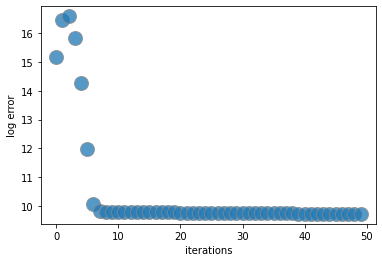

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#visulize log error
plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=14**2,  edgecolors='#888888', alpha=0.75)
plt.xlabel("iterations")
plt.ylabel("log error")
plt.show()

Actually MLlib has built in funtion to implement Linear regression with higher speed. We can see that this code gets the same result with our self-implemented code.

In [25]:
from pyspark.mllib.regression import LinearRegressionWithSGD
lr = LinearRegressionWithSGD.train(data = train, iterations = 50)
print(lr.weights)

[374.33056033371787,326.17561600868567,307.5046726216474,277.90573441077703,238.86307305304987,316.3718115014927,328.68648961942426,356.67549994893585,407.6607680697163,334.0834883450667,378.8099548803522,343.8228407879442]


Next let's use our trained model to predict on test data. The colormap is generated by the normalised train error.

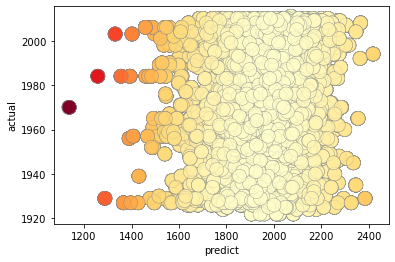

In [38]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

#get predict values,actual values and errors
pre = np.asarray(test.map(lambda lp: lr.predict(lp.features)).collect())
actual = np.asarray(test.map(lambda lp: lp.label).collect())
error = np.asarray(test.map(lambda lp: ((lp.label - lr.predict(lp.features)))**2).collect())
#set colormap
clrs = cmap(np.asarray(norm(error)))[:,0:3]
#plot
plt.scatter(pre, actual, s=14**2, c = clrs,edgecolors='#888888', alpha=0.75, linewidths=.5)
plt.xlabel("predict")
plt.ylabel("actual")
plt.show()

## References

This is just a 101 of pyspark. It can do more magical things. To learn more about pyspark, please visit the offical website. Thanks for reading. Hope you enjoy my tutorial.

https://spark.apache.org/docs/latest/rdd-programming-guide.html

https://spark.apache.org/docs/latest/api/python/pyspark.html